In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from utils.calc_time import format_data
# 超参数
num_epochs = 1000
batch_size = 32
num_classes = 5
num_shots = 1 # 每个类别的样本数
num_tasks = 32 # 元学习任务数
lr_inner = 0.4 # 内部学习率
lr_outer = 0.1 # 外部学习率
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=100)

INFO: Pandarallel will run on 100 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
import torch.nn.functional as F
class MLP(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, dropout=0.5):
        super(MLP, self).__init__()
        self.dropout = torch.nn.Dropout(dropout)

        self.hidden_1 = torch.nn.Linear(n_feature, n_hidden)  # hidden layer
        self.bn1 = torch.nn.BatchNorm1d(n_hidden)

        self.hidden_2 = torch.nn.Linear(n_hidden, n_hidden//2)
        self.bn2 = torch.nn.BatchNorm1d(n_hidden//2)

        self.hidden_3 = torch.nn.Linear(n_hidden//2, n_hidden//4)  # hidden layer
        self.bn3 = torch.nn.BatchNorm1d(n_hidden//4)

        self.hidden_4 = torch.nn.Linear(n_hidden // 4, n_hidden // 8)  # hidden layer
        self.bn4 = torch.nn.BatchNorm1d(n_hidden // 8)

        self.out = torch.nn.Linear(n_hidden//8, n_output)  # output layer

    def forward(self, x):
        x = F.relu(self.hidden_1(x))  # activation function for hidden layer
        x = self.dropout(self.bn1(x))
        x = F.relu(self.hidden_2(x))  # activation function for hidden layer
        x = self.dropout(self.bn2(x))
        x = F.relu(self.hidden_3(x))  # activation function for hidden layer
        x = self.dropout(self.bn3(x))
        x = F.relu(self.hidden_4(x))  # activation function for hidden layer
        x = self.dropout(self.bn4(x))
        x = self.out(x)
        return x

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils import data
import numpy as np
from utils import parse_opts
import warnings
warnings.filterwarnings("ignore")
def env2vec(path):
    Job_pd=pd.read_excel(path,sheet_name='Job info')
    Mac_pd=pd.read_excel(path,sheet_name='Machine info')
    Pr1_pd=pd.read_excel(path,sheet_name='Process 1 Time')
    Pr2_pd=pd.read_excel(path,sheet_name='Process 2 Time')
    # 定义问题的参数
    J = len(Job_pd)
    M = len(Mac_pd)
    W = Job_pd['准备时间'].mean()  # 订单的 Task0 和 Task1 之间的准备时间
    N = Job_pd['需求量'].values  # 订单的需求量
    A = Job_pd['到达时刻'].values  # 订单的到达时刻
    D = Job_pd['交货期'].values  # 订单的交货期
    pt= np.array([Pr1_pd[['Machine_0','Machine_1']].values,Pr2_pd[['Machine_0','Machine_1']].values])# 订单的 Task0 在生产线 i 上的单位处理时长 # 订单的 Task1 在生产线 i 上的单位处理时长
    p = np.array([Mac_pd[['闲置功率','工作功率']].values[:,0],Mac_pd[['闲置功率','工作功率']].values[:,1]])   # 生产线的闲置功率和工作功率
    rawdata=pd.concat([Job_pd,pd.DataFrame(N*p[1].mean(),columns=['预计功耗']),Pr1_pd[['Machine_0','Machine_1']],Pr2_pd[['Machine_0','Machine_1']]],axis=1).iloc[:,1:]
    rawdata=pd.concat([Job_pd,pd.DataFrame(N*p[1].mean(),columns=['预计功耗']),Pr1_pd[['Machine_0','Machine_1']],Pr2_pd[['Machine_0','Machine_1']]],axis=1).iloc[:,1:]
    column_length=len(rawdata.columns)
    rawdata=pd.concat([rawdata,rawdata.describe()])
    rawdata = rawdata.append(pd.Series(p.flatten().tolist()+[0] * (column_length-4), index=rawdata.columns), ignore_index=True)
    return rawdata.to_numpy()
def load_data(path):
    # 读取合并X和Y
    df = pd.read_csv(path)
    df['feature'] = df.path.parallel_apply(lambda x:env2vec(x.replace('./','../env/')).flatten().tolist())
    df.to_feather('/home/linjw/iProject/HA-Prototypical/env/env2vec.feather')
    # df = pd.read_feather('env/env2vec.feather')
    return df

def process_data(df, mode, type = 'MAML'):
    if mode != 'test' and type != 'MLP':
        df = np.vstack((df.values, df.values))
    else:
        df = df.values
    x = np.array(df[:,-1])
    x = np.array([list(i) for i in x],dtype=np.float32)
    y = [np.array(eval(i)).flatten() for i in df[:,-3]]
    y = np.array([list(x) for x in y])
    y_index = np.arange(len(y)) % (len(y)/2 if mode != 'test' else len(y)/2)
    return x, y_index, {i: y[i] for i in range(len(y))}, y

# 定义MAML_Dataset类
class MAML_Dataset(data.Dataset):
    def __init__(self, mode, path, test_size=0.2, random_state=0, ood = True ):
        super().__init__()
        # self.sample_len = 1024
        self.df = load_data(path)
        if ood:
            split=int(0.75*len(self.df))
            self.train_df, self.test_df = self.df.iloc[:split],self.df.iloc[split:]
        else:
            self.train_df, self.test_df = train_test_split(self.df, test_size=test_size, random_state=random_state)          
        self.x, self.y, self.label_dict, _ = process_data(self.train_df if mode != 'test' else self.test_df,mode)

    def __getitem__(self, index):
        x = np.array(self.x[index],dtype=np.float32)
        y = self.y[index]
        return x, y

    def __len__(self):
        return len(self.x)

In [12]:
dataset = MAML_Dataset('train',path='../env/bob_info.csv',ood = True)

In [13]:
dataset.train_df

,path,class,excel_num,bob,fitness,feature
0,./case1/0.xlsx,1,0,"[[20, 0, 0], [65, 1, 0], [20, 0, 1], [65, 1, 1...",37004.844,"[18.0, 12.0, 27.0, 363.0, 90.0, 11.0, 12.0, 11..."
1,./case1/1.xlsx,1,1,"[[22, 0, 0], [36, 1, 0], [22, 0, 1], [36, 1, 1...",28876.053,"[9.0, 15.0, 57.0, 537.0, 105.0, 6.0, 7.0, 9.0,..."
2,./case1/2.xlsx,1,2,"[[53, 0, 0], [2, 1, 0], [53, 0, 1], [2, 1, 1],...",32052.762,"[18.0, 12.0, 3.0, 339.0, 90.0, 11.0, 11.0, 8.0..."
3,./case1/3.xlsx,1,3,"[[19, 0, 0], [24, 1, 0], [19, 0, 1], [24, 1, 1...",33055.677,"[6.0, 18.0, 3.0, 315.0, 117.0, 5.0, 6.0, 8.0, ..."
4,./case1/4.xlsx,1,4,"[[41, 0, 0], [47, 1, 0], [41, 0, 1], [47, 1, 1...",30786.165,"[18.0, 27.0, 84.0, 396.0, 148.5, 6.0, 9.0, 12...."
...,...,...,...,...,...,...
295,./case3/95.xlsx,3,95,"[[26, 0, 0], [13, 1, 0], [26, 0, 1], [13, 1, 1...",31927.140,"[15.0, 9.0, 0.0, 960.0, 49.5, 6.0, 8.0, 10.0, ..."
296,./case3/96.xlsx,3,96,"[[23, 0, 0], [49, 1, 0], [23, 0, 1], [49, 1, 1...",33492.699,"[6.0, 9.0, 171.0, 795.0, 67.5, 10.0, 10.0, 12...."
297,./case3/97.xlsx,3,97,"[[20, 0, 0], [41, 1, 0], [20, 0, 1], [41, 1, 1...",31137.858,"[18.0, 12.0, 90.0, 1098.0, 78.0, 7.0, 7.0, 13...."
298,./case3/98.xlsx,3,98,"[[10, 0, 0], [35, 1, 0], [10, 0, 1], [35, 1, 1...",31915.848,"[18.0, 9.0, 27.0, 651.0, 72.0, 11.0, 7.0, 10.0..."


In [14]:
np.array([list(x) for x in dataset.train_df['feature'].values])

array([[18., 12., 27., ...,  0.,  0.,  0.],
       [ 9., 15., 57., ...,  0.,  0.,  0.],
       [18., 12.,  3., ...,  0.,  0.,  0.],
       ...,
       [18., 12., 90., ...,  0.,  0.,  0.],
       [18.,  9., 27., ...,  0.,  0.,  0.],
       [ 6., 21., 54., ...,  0.,  0.,  0.]])

In [15]:
np.array([list(eval(x)) for x in dataset.train_df['bob'].values]).reshape(-1,450)

array([[20,  0,  0, ..., 10,  0,  1],
       [22,  0,  0, ..., 61,  0,  1],
       [53,  0,  0, ..., 37,  0,  1],
       ...,
       [20,  0,  0, ..., 10,  0,  1],
       [10,  0,  0, ..., 67,  0,  1],
       [61,  0,  0, ..., 30,  0,  1]])

In [16]:
train_x = torch.from_numpy(np.array([list(x) for x in dataset.train_df['feature'].values])).float()
train_y = torch.from_numpy(np.array([list(eval(x)) for x in dataset.train_df['bob'].values]).reshape(-1,450)).float()
test_x = torch.from_numpy(np.array([list(x) for x in dataset.test_df['feature'].values])).float()
test_y = torch.from_numpy(np.array([list(eval(x)) for x in dataset.test_df['bob'].values]).reshape(-1,450)).float()

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
input_size = 151  # 输入特征的维度
output_size = 151  # 输出特征的维度
learning_rate = 0.01  # 学习率

model=MLP(756, 256, 450)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 400  # 迭代次数
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    # 前向传播
    inputs = train_x
    labels = train_y
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 每迭代10次打印一次损失
    # 每迭代10次打印一次损失
    with torch.no_grad():
        inputs = test_x
        labels = test_y
        predicted = model(inputs)
        loss_ = criterion(predicted, labels)
        train_losses.append(loss.item())
        test_losses.append(loss_.item())
        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item(), loss_.item()))

Epoch [1/400], Train Loss: 613.7502, Test Loss: 613.8270
Epoch [2/400], Train Loss: 613.8445, Test Loss: 613.5339
Epoch [3/400], Train Loss: 613.7633, Test Loss: 613.5811
Epoch [4/400], Train Loss: 613.4887, Test Loss: 613.5368
Epoch [5/400], Train Loss: 613.7057, Test Loss: 613.5656
Epoch [6/400], Train Loss: 613.3854, Test Loss: 613.3572
Epoch [7/400], Train Loss: 613.5684, Test Loss: 613.7510
Epoch [8/400], Train Loss: 613.4158, Test Loss: 613.3116
Epoch [9/400], Train Loss: 613.3096, Test Loss: 613.2618
Epoch [10/400], Train Loss: 613.3209, Test Loss: 613.2961
Epoch [11/400], Train Loss: 613.2839, Test Loss: 613.2408
Epoch [12/400], Train Loss: 613.0135, Test Loss: 613.1801
Epoch [13/400], Train Loss: 613.1271, Test Loss: 613.2778
Epoch [14/400], Train Loss: 613.1339, Test Loss: 613.0110
Epoch [15/400], Train Loss: 613.0269, Test Loss: 612.8630
Epoch [16/400], Train Loss: 612.9936, Test Loss: 612.8726
Epoch [17/400], Train Loss: 612.9604, Test Loss: 613.4122
Epoch [18/400], Train L

In [18]:
pd.DataFrame([train_losses,test_losses],index=['train_error','valid_error']).T.to_csv('result/MLP_ood_loss.csv',index=False)

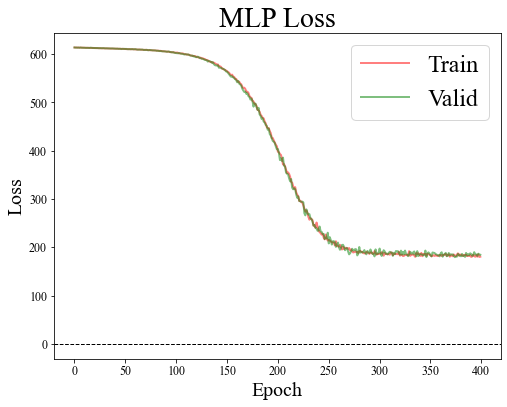

In [19]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')
# 生成随机数据
x = np.arange(0, 400)
y1 = train_losses
y2 = test_losses
# 计算移动平均值
window_size = 10
window = np.ones(window_size) / float(window_size)
y_smooth = np.convolve(y1, window, 'same')

# 绘图
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y1, alpha=0.5, color='red', linewidth=2, label='Train')
ax.plot(x, y2, alpha=0.5, color='green', linewidth=2, label='Valid')
# 界限线
ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
# 标题和标签
ax.set_title('MLP Loss', fontsize=28)
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)
# 图例
ax.legend(loc='best', fontsize=24)

plt.show()

In [20]:
test_df=dataset.test_df
test_df.index=range(len(test_df))

In [21]:
import sys
sys.path.append('../heuristic')
from methods.common import parse_env,ruler,calculate_cost,fitness

In [22]:
product_list=[ruler(x.reshape(150,3),75) for x in predicted.numpy()]
product_list

[[[21, 1, 0],
  [6, 1, 0],
  [63, 0, 0],
  [10, 0, 0],
  [62, 0, 0],
  [3, 1, 0],
  [70, 0, 0],
  [0, 1, 0],
  [52, 1, 0],
  [1, 1, 0],
  [46, 0, 0],
  [0, 1, 1],
  [37, 0, 0],
  [4, 1, 0],
  [13, 0, 0],
  [4, 1, 1],
  [46, 0, 1],
  [37, 1, 1],
  [69, 0, 0],
  [64, 1, 0],
  [58, 0, 0],
  [1, 1, 1],
  [58, 1, 1],
  [2, 1, 0],
  [31, 1, 0],
  [17, 1, 0],
  [44, 0, 0],
  [13, 0, 1],
  [51, 0, 0],
  [3, 1, 1],
  [62, 0, 1],
  [12, 0, 0],
  [29, 0, 0],
  [9, 1, 0],
  [34, 0, 0],
  [17, 1, 1],
  [68, 0, 0],
  [23, 0, 0],
  [57, 1, 0],
  [5, 1, 0],
  [66, 1, 0],
  [10, 1, 1],
  [48, 1, 0],
  [5, 1, 1],
  [42, 0, 0],
  [6, 1, 1],
  [33, 0, 0],
  [16, 0, 0],
  [55, 1, 0],
  [23, 0, 1],
  [66, 0, 1],
  [49, 0, 0],
  [54, 0, 0],
  [36, 1, 0],
  [53, 1, 0],
  [41, 0, 0],
  [11, 1, 0],
  [9, 0, 1],
  [19, 1, 0],
  [7, 1, 0],
  [39, 1, 0],
  [22, 1, 0],
  [56, 0, 0],
  [38, 0, 0],
  [45, 0, 0],
  [15, 1, 0],
  [71, 0, 0],
  [52, 1, 1],
  [54, 0, 1],
  [24, 1, 0],
  [63, 0, 1],
  [11, 1, 1],
  [21, 0

In [23]:
predicted_time_list = []
for i, file_name in test_df.iterrows():
    excel_name = file_name['path'].replace('./','../env/')
    order = product_list[i]
    J, M, A, D, N, pt, p, W = parse_env(excel_name)
    predicted_time_list.append(-fitness(order, J, M, A, D, N, pt, p, W))
predicted_time_list = format_data(predicted_time_list,0)
# Convert the object results for the test dataset to a list
true_time_list = test_df['fitness'].values.tolist()


# Calculate the performance metrics
error_list = []
percent_error_list = []
for i in range(len(true_time_list)):
    true_time_list[i] = float(true_time_list[i])
    predicted_time_list[i] = float(predicted_time_list[i])
    error_list.append(true_time_list[i] - predicted_time_list[i])
    percent_error_list.append((true_time_list[i] - predicted_time_list[i]) / true_time_list[i])

# Create a dataframe with the performance metrics and write it to an Excel file
performance_df = pd.DataFrame(columns=['average error', 'average percent error', 'predicted time average', 'predicted time max', 'predicted time min'])
performance_df.loc[0] = [sum(error_list)/len(error_list), sum(percent_error_list)/len(percent_error_list), sum(predicted_time_list)/len(predicted_time_list), max(predicted_time_list), min(predicted_time_list)]

In [24]:
pd.DataFrame([true_time_list,predicted_time_list],index=['Predict','GroundTruth']).T.to_csv('./output/MLP_ood_label.csv',index=False)
pd.DataFrame([true_time_list,predicted_time_list],index=['Predict','GroundTruth']).T

,Predict,GroundTruth
0,73493.004,64913.842556
1,58537.020,55048.362047
2,60321.174,54651.168884
3,60002.925,57360.965598
4,64591.020,58149.196054
...,...,...
95,62087.640,64161.835940
96,60011.139,59024.397900
97,66093.708,60396.804807
98,59546.985,65857.388210


In [25]:
performance_df

,average error,average percent error,predicted time average,predicted time max,predicted time min
0,742.659331,0.011397,59902.567259,74799.073832,50490.089954
